In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import time
import threading
from threading import Semaphore
import copy
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

# Set device for model training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Global Configuration
FILE_PATH = 'London_Weather.csv'

Say for example, T = 3 (Sliding Window), D = 10 (Days of weather data), N = 10 - 3 = 7 (Possible sequences)

If the ratio of train_size is 0.6 then the first 4 sequences will be for training and rest for testing

| Index | Sequences (X)     | Targets (y) |                        |
|-------|-------------------|-------------|------------------------|
| 1     | Days [1, 2, 3]    | Day 4       | First test sequence    |
| 2     | Days [2, 3, 4]    | Day 5       |                        |
| 3     | Days [3, 4, 5]    | Day 6       |                        |
| 4     | Days [4, 5, 6]    | Day 7       | Last training sequence |
| 5     | Days [5, 6, 7]    | Day 8       | First test sequence    |
| 6     | Days [6, 7, 8]    | Day 9       |                        |
| 7     | Days [7, 8, 9]    | Day 10      | Last test sequence     |

In [2]:
# Preprocessing Class
TRAIN_RATIO = 0.8
TARGET_COLUMN = 'precipitation'
SEQUENCE_LENGTH = 7  # To make prediction based on past SEQUENCE_LENGTH for LSTM

# Buffer Configuration
CAPACITY = 15  # Number of batches to store in buffer
TRAINER_READ_THRESHOLD = 3  # Number of batches for training
INFERENCE_READ_THRESHOLD = 1  # Number of batches for inference

# Training Class
PRETRAINED_MODEL = None  # Load a pretrained model (If available)
LEARNING_RATE = 0.001
EARLY_STOP = 25  # If validation does not improve for 25 epochs, stop training
EPOCHS = 300
HIDDEN_DIM = 512
LAYER_DIM = 2
DROPOUT = 0.3  # Randomly turns off 30% of neurons during training to prevent overfitting

# Inference Class
BATCH_SIZE = 64

# Simulated processing times (seconds)
PREPROCESSING_WAIT_TIME = 1  # Data loading is I/O bound (Fastest)
TRAINER_WAIT_TIME = 4  # Training is compute intensive (Slowest)
INFERENCE_WAIT_TIME = 1  # Inference (Moderate)
ANALYSIS_WAIT_TIME = 0.3  # Analysis is typically quick
DISPLAY_WAIT_TIME = 0.7  # Display/Visualization takes some time

# Create shared data buffers
# Two buffers: one for Training, one for Inference
data_buffer1 = [None] * CAPACITY  # Stores Training batches (Batch, Sequence, Features)
data_buffer2 = [None] * CAPACITY  # Stores Individual datapoints

# Ensures mutual exclusion for buffer access
mutex1 = Semaphore(1)  # Protects access to buffer1
mutex2 = Semaphore(1)  # Protects access to buffer2

# Tracks the Empty Slots in the buffer
empty1 = Semaphore(CAPACITY)  # Counts empty slots in buffer1
empty2 = Semaphore(CAPACITY)  # Counts empty slots in buffer2

# Tracks the Filled Slots in the buffer
full1 = Semaphore(0)  # Counts filled slots in buffer1
full2 = Semaphore(0)  # Counts filled slots in buffer2

# Events to track completion
preprocessing_done = threading.Event()
preprocessing_test_data_ready = threading.Event()  # Event to signal test data is ready for Training
training_done = threading.Event()
inference_done = threading.Event()
analysis_done = threading.Event()
display_done = threading.Event()

# Shared Dictionaries to store results
training_results = {}  # Store results from Training
inference_results = {}  # Store results from Inference
analysis_results = {}  # Store results from Analysis

# Mutex for accessing shared result dictionaries
results_mutex = threading.Lock()

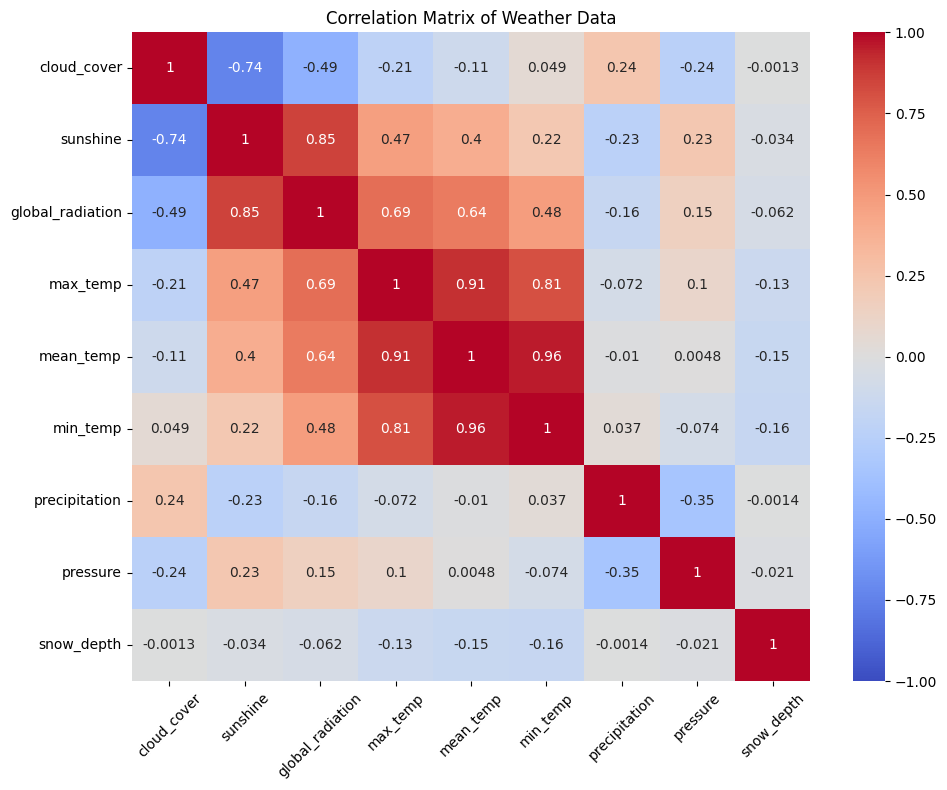

In [3]:
# Load the dataset
df = pd.read_csv(FILE_PATH)
numeric_df = df.select_dtypes(include=['float64'])

# Compute the correlation matrix
corr = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Weather Data")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### One-Hot Encoding

One-hot encoding is used to **numerically encode categorical variables** without introducing order.
It transforms a single `season` column into **multiple binary columns**, each representing a unique season.

| season_spring | season_summer | season_winter | season_fall |
|---------------|---------------|---------------|-------------|
| 1             | 0             | 0             | 0           |
| 0             | 1             | 0             | 0           |
| 0             | 0             | 1             | 0           |
| 0             | 0             | 0             | 1           |
| 0             | 1             | 0             | 0           |

Each row now has exactly **one ‘1’** in the column that represents the season, and **‘0’** in the others—hence the term **“one-hot”**.


In [4]:
class Preprocessing(threading.Thread):
    def __init__(self, file_path, seq_length=SEQUENCE_LENGTH, preprocess_wait_time=PREPROCESSING_WAIT_TIME, train_ratio=TRAIN_RATIO, target_column=TARGET_COLUMN):
        threading.Thread.__init__(self)
        self.file_path = file_path
        self.data = None
        self.scaler = None
        self.normalized_data = None
        self.train_size = None
        self.X_train_seq = None
        self.y_train_seq = None
        self.X_test_seq = None
        self.y_test_seq = None
        self.seq_length = seq_length
        self.wait_time = preprocess_wait_time
        self.train_ratio = train_ratio
        self.target_column = target_column

    def load_data(self):
        self.data = pd.read_csv(self.file_path)
        return self.data

    def clean_data(self):
        # Convert date to datetime format
        self.data['date'] = pd.to_datetime(self.data['date'], format='%Y%m%d')

        # Extracting calender-based features
        self.data['day_of_year'] = self.data['date'].dt.dayofyear
        self.data['month'] = self.data['date'].dt.month
        self.data['day'] = self.data['date'].dt.day

        # Divides each month into 4 seasons
        self.data['season'] = (self.data['month'] % 12 + 3) // 3  # 1: Spring, 2: Summer, 3: Fall, 4: Winter
        self.data['is_weekend'] = self.data['date'].dt.dayofweek >= 5  # 1: Weekend, 0: Weekday

        # Converting categorical features to numerical format
        season_dummies = pd.get_dummies(self.data['season'], prefix='season')
        self.data = pd.concat([self.data, season_dummies], axis=1)

        # Fill missing values in snow_depth with 0
        self.data['snow_depth'].fillna(0, inplace=True)

        # Drop rows with any NaN values
        self.data.dropna(inplace=True)

        return self.data

    def prepare_data_for_model(self, train_ratio=None, target_column=None, seq_length=None):
        train_ratio = train_ratio if train_ratio is not None else self.train_ratio
        target_column = target_column if target_column is not None else self.target_column
        seq_length = seq_length if seq_length is not None else self.seq_length

        # Calculate train size
        self.train_size = int(len(self.data) * train_ratio)

        # Lag - A value from the previous day (Useful for the short term prediction for LSTM)
        # For example, precip_lag_1 means "What was the precipitation 1 day ago?"
        for lag in range(1, 4):  # Use 3 lags
            self.data[f'precip_lag_{lag}'] = self.data[target_column].shift(lag)
            self.data[f'pressure_lag_{lag}'] = self.data['pressure'].shift(lag)
            self.data[f'cloud_cover_lag_{lag}'] = self.data['cloud_cover'].shift(lag)

        # Averages - A moving average over the last 3 and 7 days
        # For example, precip_ma_3 means "What was the average precipitation over the last 3 days?"
        self.data['precip_ma_3'] = self.data[target_column].rolling(window=3).mean()
        self.data['precip_ma_7'] = self.data[target_column].rolling(window=7).mean()
        self.data['pressure_ma_3'] = self.data['pressure'].rolling(window=3).mean()
        self.data['cloud_cover_ma_3'] = self.data['cloud_cover'].rolling(window=3).mean()

        # Remove rows with NaN due to lagging/moving averages
        self.data.dropna(inplace=True)

        # Select features based on correlation analysis and domain knowledge
        selected_columns = [
            'pressure', 'cloud_cover', 'sunshine',
            'precip_lag_1', 'precip_lag_2', 'precip_lag_3',
            'pressure_lag_1', 'pressure_lag_2', 'pressure_lag_3',
            'cloud_cover_lag_1', 'cloud_cover_lag_2', 'cloud_cover_lag_3',
            'precip_ma_3', 'precip_ma_7', 'pressure_ma_3', 'cloud_cover_ma_3',
            'day_of_year', 'month', 'season_1', 'season_2', 'season_3', 'season_4'
        ]

        # Prepare input data and target
        X = self.data[selected_columns]
        y = self.data[target_column].values

        # Split data
        X_train, X_test = X[:self.train_size], X[self.train_size:]
        y_train, y_test = y[:self.train_size], y[self.train_size:]

        # Scale features using robust scaler (less sensitive to outliers)
        # Works based on median and IQR (Inter-quartile Range)
        self.scaler = RobustScaler()
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Create sequences for LSTM
        train_data = np.column_stack([X_train_scaled, y_train])
        test_data = np.column_stack([X_test_scaled, y_test])

        X_train_seq, y_train_seq = self.create_sequences(train_data, seq_length)
        X_test_seq, y_test_seq = self.create_sequences(test_data, seq_length)

        # Convert to PyTorch tensors for LSTM
        self.X_train_seq = torch.FloatTensor(X_train_seq)
        self.y_train_seq = torch.FloatTensor(y_train_seq).unsqueeze(1)  # Add extra dimension for LSTM due to single value sequence
        self.X_test_seq = torch.FloatTensor(X_test_seq)
        self.y_test_seq = torch.FloatTensor(y_test_seq).unsqueeze(1)  # Add extra dimension for LSTM due to single value sequence

        return self.X_train_seq, self.y_train_seq, self.X_test_seq, self.y_test_seq

    def create_sequences(self, data, seq_length):
        xs = []
        ys = []

        # For every window of seq_length days, the next days precipitation is the target
        for i in range(len(data) - seq_length):
            x = data[i:(i + seq_length)]
            y = data[i + seq_length, 0]  # Target is the first column (precipitation)
            xs.append(x)
            ys.append(y)

        return np.array(xs), np.array(ys)

    def run(self):
        # Preprocess start time
        start_time_pre = time.time()

        # Load and prepare data
        self.load_data()
        self.clean_data()

        X_train_seq, y_train_seq, X_test_seq, y_test_seq = self.prepare_data_for_model()

        # Store test data first so Training thread can access it
        with results_mutex:
            training_results['original_data'] = self.data
            training_results['X_test_seq'] = self.X_test_seq
            training_results['y_test_seq'] = self.y_test_seq

        # Signal that test data is ready for Training thread
        preprocessing_test_data_ready.set()

        # Calculate batch size to divide data into CAPACITY chunks
        batch_size = max(1, len(X_train_seq) // CAPACITY)

        # Fill both buffers with batches
        datapoints_loaded = 0
        in_index1 = 0  # Indices for Buffer 1 (Training)
        in_index2 = 0  # Indices for Buffer 2 (Inference)

        while datapoints_loaded < CAPACITY:
            # Simulate processing time (I/O bound)
            time.sleep(self.wait_time)

            # Create a batch boundaries
            start_idx = datapoints_loaded * batch_size
            end_idx = min(start_idx + batch_size, len(X_train_seq))

            # Prevent out-of-bounds
            if start_idx >= len(X_train_seq):
                break

            # Get batch of data
            batch_X = X_train_seq[start_idx:end_idx]
            batch_y = y_train_seq[start_idx:end_idx]

            # Fill buffer 1 for training (chunks)
            empty1.acquire()  # Wait for empty slot
            mutex1.acquire()  # Acquire Lock (Mutual Exclusion, Thread Safe Access)
            data_buffer1[in_index1] = (batch_X, batch_y)  # Store batch in buffer
            print(f"[PREPROCESSING] Added batch to training buffer at index: {in_index1}, batch size: {len(batch_X)}")
            in_index1 = (in_index1 + 1) % CAPACITY  # Update index of the buffer
            mutex1.release()  # Release Lock
            full1.release()  # Buffer slot is full (Permit to consume)

            # Fill buffer 2 for inference (single datapoints)
            empty2.acquire()  # Wait for empty slot
            mutex2.acquire()  # Acquire Lock (Mutual Exclusion, Thread Safe Access)
            # Stores individual datapoints for inference
            data_buffer2[in_index2] = (X_test_seq[datapoints_loaded % len(X_test_seq):datapoints_loaded % len(X_test_seq) + 1],
                                      y_test_seq[datapoints_loaded % len(X_test_seq):datapoints_loaded % len(X_test_seq) + 1])
            print(f"[PREPROCESSING] Added datapoint to inference buffer at index: {in_index2}")
            in_index2 = (in_index2 + 1) % CAPACITY  # Update index of the buffer
            mutex2.release()  # Release Lock
            full2.release()  # Buffer slot is full (Permit to consume)

            datapoints_loaded += 1

        end_time_pre = time.time()
        print(f"[PREPROCESSING] Completed in {end_time_pre - start_time_pre:.2f} seconds")

        # Set the Preprocessing event as completed
        preprocessing_done.set()

https://www.kaggle.com/code/dannykliu/lstm-with-attention-clr-in-pytorch

In [5]:
class LSTMAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout=DROPOUT):
        super(LSTMAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Attention layer - Learns to give attention to certain days more than others
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

        # Takes the weighted average of important days and outputs the final prediction
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, x):
        batch_size = x.size(0)

        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)

        # LSTM forward
        lstm_out, _ = self.lstm(x, (h0, c0))  # lstm_out shape: (batch_size, seq_len, hidden_dim)

        # Calculate attention weights
        attention_weights = self.attention(lstm_out)  # You get one attention score per day
        attention_weights = torch.softmax(attention_weights, dim=1)  # Sum of all the attention weights = 1

        # Apply attention to LSTM output
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)

        # Final prediction
        output = self.fc(context_vector)

        return output

In [6]:
class AsymmetricMSELoss(nn.Module):
    def __init__(self, underestimation_weight=1.5):
        super(AsymmetricMSELoss, self).__init__()
        self.underestimation_weight = underestimation_weight  # If the model underestimates the precipitation, apply a higher penalty

    def forward(self, predictions, targets):
        # Calculate residuals
        # Greater than 0 means the model underestimated
        # Less than 0 means the model overestimated
        residuals = targets - predictions

        # Apply higher penalty to underestimation
        # If the model underestimates, multiply the residual by the underestimation weight
        # If the model overestimates, keep the residual as is
        weighted_residuals = torch.where(
            residuals > 0,
            residuals * self.underestimation_weight,
            residuals
        )

        # Compute MSE with weighted residuals
        loss = torch.mean(weighted_residuals ** 2)
        return loss


- If train loss is low, but val loss/test loss is high → your model is overfitting.
- If all three are similar and low → your model is generalizing well.

In [7]:
class Training(threading.Thread):
    def __init__(self, pretrained_model=PRETRAINED_MODEL, trainer_wait_time=TRAINER_WAIT_TIME,
                 hidden_dim=HIDDEN_DIM, layer_dim=LAYER_DIM, learning_rate=LEARNING_RATE,
                 epochs=EPOCHS, early_stop=EARLY_STOP):
        threading.Thread.__init__(self)
        self.model = pretrained_model
        self.device = device
        self.all_train_losses = []
        self.all_test_losses = []
        self.wait_time = trainer_wait_time
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.early_stop = early_stop

    def create_model(self, input_dim, hidden_dim=None, layer_dim=None, output_dim=1):
        hidden_dim = hidden_dim if hidden_dim is not None else self.hidden_dim
        layer_dim = layer_dim if layer_dim is not None else self.layer_dim

        self.model = LSTMAttention(input_dim, hidden_dim, layer_dim, output_dim, dropout=DROPOUT)
        self.model.to(self.device)
        return self.model

    def train_model(self, X_train, y_train, X_val, y_val, epochs=None, patience=None):
        epochs = epochs if epochs is not None else self.epochs
        patience = patience if patience is not None else self.early_stop

        # Loss to prevent underestimation more than overestimation
        criterion = AsymmetricMSELoss(underestimation_weight=1.5)

        # Adam adapts learning rates for each parameter
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=1e-5)

        # Scheduler to reduce learning rate when validation loss plateaus
        # Reduces the learning rate by 50% if the validation loss does not improve for 10 epochs
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

        train_losses = []
        val_losses = []
        best_val_loss = float('inf')
        best_model_state = None
        patience_counter = 0

        for epoch in range(epochs):
            # Training
            self.model.train()
            optimizer.zero_grad()
            outputs = self.model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()

            # Scales the gradient to 1 or less
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            optimizer.step()  # Update weights

            # Validation
            self.model.eval()  # Disables Dropout and BatchNorm
            with torch.no_grad():
                val_outputs = self.model(X_val)
                val_loss = criterion(val_outputs, y_val)

                # Use standard MSE for monitoring
                val_mse = nn.MSELoss()(val_outputs, y_val)

            train_losses.append(loss.item())
            val_losses.append(val_loss.item())

            # Update learning rate based on validation loss
            scheduler.step(val_loss)

            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = self.model.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # Load best model state
        if best_model_state is not None:
            self.model.load_state_dict(best_model_state)

        return self.model, train_losses, val_losses

    def run(self):
        # Training start time
        start_time_train = time.time()

        # Wait for test data to be available
        preprocessing_test_data_ready.wait()

        # Read data from buffer in chunks
        read_datapoints = 0
        out_index = 0

        # Get test data for validation
        with results_mutex:
            X_test_seq = training_results['X_test_seq']
            y_test_seq = training_results['y_test_seq']

        # Wait for first data batch
        full1.acquire()  # Wait until buffer has at least one batch
        mutex1.acquire()  # Acquire Lock

        # Get first batch to determine dimensions for model creation
        batch_X, batch_y = data_buffer1[0]
        input_dim = batch_X.shape[2]  # Number of features for LSTM

        # Create model if not already created
        if self.model is None:
            self.model = self.create_model(input_dim)
        elif hasattr(self.model, 'to'):
            self.model.to(self.device)

        mutex1.release()  # Release Lock
        full1.release()  # Release Permit

        # LSTM validation set
        # Use the first 100 samples of the test set for validating our model during training
        val_size = min(100, len(X_test_seq))
        X_val = X_test_seq[:val_size].to(self.device)
        y_val = y_test_seq[:val_size].to(self.device)

        # Train the model
        while read_datapoints < CAPACITY:
            # Determine number of batches to read
            batch_count = min(TRAINER_READ_THRESHOLD, CAPACITY - read_datapoints)

            # Skip if no more batches to read
            if batch_count <= 0:
                break

            # Acquire permits for batches
            for _ in range(batch_count):
                full1.acquire()  # Wait until buffer has data

            mutex1.acquire()  # Acquire Lock

            # Collect data chunks for training
            trainer_data_to_load = []
            trainer_targets_to_load = []

            # Read batches
            for i in range(batch_count):
                idx = (out_index + i) % CAPACITY  # Get index of the buffer
                if data_buffer1[idx] is not None:
                    batch_X, batch_y = data_buffer1[idx]  # Get batch data
                    trainer_data_to_load.append(batch_X)
                    trainer_targets_to_load.append(batch_y)

            print(f"[TRAINING] Read {batch_count} batches from indices: {out_index} to {(out_index + batch_count - 1) % CAPACITY}")

            # Update buffer index and counter
            out_index = (out_index + batch_count) % CAPACITY
            read_datapoints += batch_count

            mutex1.release()  # Release Lock

            # Release permits for consumed batches
            for _ in range(batch_count):
                empty1.release()  # Signal empty slot in buffer

            # Combine batches for training
            if len(trainer_data_to_load) > 0:
                # Simulate processing time
                time.sleep(self.wait_time)

                # Combine batches if we have more than one
                if len(trainer_data_to_load) > 1:
                    combined_X = torch.cat(trainer_data_to_load).to(self.device)
                    combined_y = torch.cat(trainer_targets_to_load).to(self.device)
                else:
                    combined_X = trainer_data_to_load[0].to(self.device)
                    combined_y = trainer_targets_to_load[0].to(self.device)

                # Train the LSTM model
                self.model, batch_train_losses, batch_test_losses = self.train_model(
                    combined_X,
                    combined_y,
                    X_val,
                    y_val
                )

                # Store losses for plotting
                self.all_train_losses.extend(batch_train_losses)
                self.all_test_losses.extend(batch_test_losses)

        end_time_train = time.time()
        print(f"[TRAINING] Completed in {end_time_train - start_time_train:.2f} seconds")

        # Store training results for other threads to access
        with results_mutex:
            training_results['model'] = copy.deepcopy(self.model)
            training_results['train_losses'] = self.all_train_losses
            training_results['test_losses'] = self.all_test_losses

        # Set the Training event as completed
        training_done.set()

In [8]:
class Inference(threading.Thread):
    def __init__(self, inference_wait_time=INFERENCE_WAIT_TIME, batch_size = BATCH_SIZE):
        threading.Thread.__init__(self)
        self.model = None
        self.device = device
        self.predictions = []  # Store predictions for the entire data set
        self.buffer_predictions = []  # Store predictions of the individual datapoints from the buffer
        self.wait_time = inference_wait_time
        self.batch_size = batch_size

    def set_model(self, model):
        self.model = model
        self.model.to(self.device)

    def predict(self, X_test):
        # Ensure data is on the device
        X_test = X_test.to(self.device)

        # Set model to evaluation mode
        self.model.eval()  # Disables Dropout and BatchNorm

        # Make prediction
        with torch.no_grad():  # No need to track the gradients
            prediction = self.model(X_test)[0, 0].item()

        return prediction

    def predict_all(self, X_test):
        # Move data to device
        X_test = X_test.to(self.device)

        # Set model to evaluation mode
        self.model.eval()

        # Store predictions
        all_predictions = []

        # Generate predictions batch by batch to avoid memory issues
        with torch.no_grad():
            for i in range(0, len(X_test), self.batch_size):
                batch = X_test[i:i+self.batch_size]
                outputs = self.model(batch)
                all_predictions.extend(outputs.cpu().numpy().flatten())

        return all_predictions

    def run(self):
        # Inference start time
        start_time_inf = time.time()

        # Wait for training to provide a model
        training_done.wait()

        # Get the trained model and test data
        with results_mutex:
            self.model = training_results['model']
            X_test = training_results['X_test_seq']

        # Generate predictions for all test data
        # Later used for plotting and analysis
        self.predictions = self.predict_all(X_test)

        read_datapoints = 0
        out_index = 0
        buffer_predictions = []

        while read_datapoints < CAPACITY:
            # Simulate processing time
            time.sleep(self.wait_time)

            # Acquire permits for INFERENCE_READ_THRESHOLD datapoints
            batch_count = min(INFERENCE_READ_THRESHOLD, CAPACITY - read_datapoints)
            for _ in range(batch_count):
                full2.acquire()  # Wait until buffer has data

            mutex2.acquire()  # Acquire Lock (Mutual Exclusion, Thread Safe Access)

            # Read and predict each datapoint from the buffer
            for i in range(batch_count):
                idx = (out_index + i) % CAPACITY
                if data_buffer2[idx] is not None:
                    test_X, test_y = data_buffer2[idx]

                    # Make prediction
                    prediction = self.predict(test_X)
                    buffer_predictions.append(prediction)

            # Update buffer index
            out_index = (out_index + batch_count) % CAPACITY
            read_datapoints += batch_count

            mutex2.release()  # Release Lock

            # Release permits for consumed datapoints
            for _ in range(batch_count):
                empty2.release()  # Signal empty slot in buffer

        end_time_inf = time.time()
        print(f"[INFERENCE] Completed in {end_time_inf - start_time_inf:.2f} seconds")

        # Store inference results for analysis
        with results_mutex:
            inference_results['predictions'] = self.predictions
            inference_results['buffer_predictions'] = buffer_predictions
            if 'y_test_seq' in training_results:
                inference_results['y_test'] = training_results['y_test_seq'][:len(self.predictions)]

        # Set the Inference event as completed
        inference_done.set()

In [9]:
class Analysis(threading.Thread):
    def __init__(self, analyse_wait_time=ANALYSIS_WAIT_TIME):
        threading.Thread.__init__(self)
        self.true_values = None
        self.predictions = None
        self.metrics = {}
        self.errors = None
        self.error_stats = {}
        self.binary_metrics = {}
        self.wait_time = analyse_wait_time

    def calculate_metrics(self, true_values=None, predictions=None):
        true_values = true_values if true_values is not None else self.true_values
        predictions = predictions if predictions is not None else self.predictions

        # Calculate MAE
        self.metrics['MAE'] = mean_absolute_error(true_values, predictions)

        # Calculate MSE
        self.metrics['MSE'] = mean_squared_error(true_values, predictions)

        # Calculate R-MSE
        self.metrics['RMSE'] = np.sqrt(self.metrics['MSE'])

        # Calculate R²
        self.metrics['R2'] = r2_score(true_values, predictions)

        print(f"[ANALYSIS] Metrics - MAE: {self.metrics['MAE']:.3f}, MSE: {self.metrics['MSE']:.3f}, "
              f"RMSE: {self.metrics['RMSE']:.3f}, R²: {self.metrics['R2']:.3f}")

        return self.metrics

    def analyze_error_distribution(self, true_values=None, predictions=None):
        # Helps us understand how well the model is performing for rainy and non-rainy days
        true_values = true_values if true_values is not None else self.true_values
        predictions = predictions if predictions is not None else self.predictions

        # Calculate errors
        self.errors = true_values.flatten() - np.array(predictions)

        # Basic statistics of errors
        self.error_stats = {
            'mean': np.mean(self.errors),
            'std': np.std(self.errors),
            'min': np.min(self.errors),
            'max': np.max(self.errors),
            'median': np.median(self.errors)
        }

        # Calculate error statistics for days with and without precipitation
        zero_precip_mask = true_values.flatten() == 0
        non_zero_precip_mask = true_values.flatten() > 0

        # Add error statistics for precipitation/non-precipitation days if we have any
        if np.any(zero_precip_mask):
            self.error_stats['zero_precip_mae'] = mean_absolute_error(
                true_values.flatten()[zero_precip_mask],
                np.array(predictions)[zero_precip_mask]
            )

        if np.any(non_zero_precip_mask):
            self.error_stats['non_zero_precip_mae'] = mean_absolute_error(
                true_values.flatten()[non_zero_precip_mask],
                np.array(predictions)[non_zero_precip_mask]
            )

            self.error_stats['percent_with_precip'] = np.mean(non_zero_precip_mask) * 100

        print(f"[ANALYSIS] Error stats - Mean: {self.error_stats['mean']:.3f}, "
              f"Std: {self.error_stats['std']:.3f}")

        return self.errors, self.error_stats

    def run(self):
        # Analysis start time
        start_time_ana = time.time()

        # Wait for training and inference to complete
        inference_done.wait()

        # Simulate processing time
        time.sleep(self.wait_time)

        # Get predictions and true values
        with results_mutex:
            self.predictions = inference_results['predictions']
            self.true_values = inference_results['y_test'].numpy()

        # Calculate metrics
        self.calculate_metrics()

        # Analyze error distribution
        self.analyze_error_distribution()

        end_time_ana = time.time()
        print(f"[ANALYSIS] Completed in {end_time_ana - start_time_ana:.2f} seconds")

        # Store analysis results
        with results_mutex:
            analysis_results['metrics'] = self.metrics
            analysis_results['errors'] = self.errors
            analysis_results['error_stats'] = self.error_stats

        # Set the Analysis event as completed
        analysis_done.set()

In [10]:
class Display(threading.Thread):
    def __init__(self, display_wait_time=DISPLAY_WAIT_TIME, show_loss_plot=True, show_main_plot=True,
                 show_yearly_plot=True, show_error_hist=True, show_scatter_plot=True):
        threading.Thread.__init__(self)
        self.data = None
        self.predictions = None
        self.dates = None
        self.plot_df = None
        self.test_target = None
        self.train_losses = None
        self.test_losses = None
        self.errors = None
        self.metrics = None
        self.error_stats = None
        self.wait_time = display_wait_time
        self.show_loss_plot = show_loss_plot
        self.show_main_plot = show_main_plot
        self.show_yearly_plot = show_yearly_plot
        self.show_error_hist = show_error_hist
        self.show_scatter_plot = show_scatter_plot

    def prepare_plot_data(self):
        # Get data from shared results
        with results_mutex:
            self.data = training_results['original_data']
            self.predictions = inference_results['predictions']
            self.test_target = inference_results['y_test']
            self.train_losses = training_results['train_losses']
            self.test_losses = training_results['test_losses']
            self.errors = analysis_results['errors'] if 'errors' in analysis_results else None
            self.metrics = analysis_results['metrics'] if 'metrics' in analysis_results else None
            self.error_stats = analysis_results['error_stats'] if 'error_stats' in analysis_results else None

        # Prepare the plot DataFrame
        # Use proper alignment for test data
        train_size = int(len(self.data) * TRAIN_RATIO)

        # Adjust dates to account for sequence length
        test_dates = self.data.iloc[train_size + SEQUENCE_LENGTH:]['date'].reset_index(drop=True)
        if len(test_dates) > len(self.predictions):
            test_dates = test_dates[:len(self.predictions)]

        # Create results dataframe with columns
        test_values = self.test_target.cpu().numpy().flatten()[:len(self.predictions)]
        self.plot_df = pd.DataFrame({
            'date': test_dates[:len(self.predictions)],
            'actual': test_values,
            'predicted': self.predictions[:len(self.predictions)]
        })

        # Show sample of prediction dataframe
        print("[DISPLAY] Sample of prediction dataframe:")
        print(self.plot_df.head(5))

    def plot_training_history(self, figsize=(12, 8)):
        plt.figure(figsize=figsize)
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('LSTM Training and Validation Loss')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_results(self, title=None, figsize=(20, 10)):
        plt.figure(figsize=figsize)
        plt.plot(self.plot_df['date'], self.plot_df['actual'], label='Actual Precipitation', alpha=0.7)
        plt.plot(self.plot_df['date'], self.plot_df['predicted'], label='Predicted Precipitation', alpha=0.7)
        plt.xlabel('Date')
        plt.ylabel('Precipitation (mm)')
        plt.legend(loc='upper right')

        if title:
            plt.title(title)

        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_by_year(self, figsize=(20, 10)):
        # Group data by year
        self.plot_df['year'] = self.plot_df['date'].dt.year
        years = self.plot_df['year'].unique()

        # Plot each year separately
        for year in years:
            year_data = self.plot_df[self.plot_df['year'] == year]

            plt.figure(figsize=figsize)
            plt.plot(year_data['date'], year_data['actual'], label='Actual Precipitation', alpha=0.7)
            plt.plot(year_data['date'], year_data['predicted'], label='Predicted Precipitation', alpha=0.7)
            plt.xlabel('Date')
            plt.ylabel('Precipitation (mm)')
            plt.legend(loc='upper right')
            plt.title(f'Precipitation in {year} (LSTM Model)')
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    def plot_error_histogram(self, figsize=(12, 8)):
        if self.errors is not None:
            plt.figure(figsize=figsize)
            plt.hist(self.errors, bins=50, alpha=0.7)
            plt.axvline(x=0, color='r', linestyle='--')
            plt.xlabel('Prediction Error (Actual - Predicted)')
            plt.ylabel('Frequency')
            plt.title('Distribution of Prediction Errors')
            plt.grid(True)
            plt.show()

    def plot_scatter(self, figsize=(10, 10)):
        if self.test_target is not None and self.predictions is not None:
            plt.figure(figsize=figsize)
            true_vals = self.test_target.cpu().numpy().flatten()[:len(self.predictions)]
            plt.scatter(true_vals, self.predictions, alpha=0.5)
            max_val = max(max(np.max(true_vals), np.max(self.predictions)), abs(min(np.min(true_vals), np.min(self.predictions))))
            plt.plot([-max_val, max_val], [-max_val, max_val], 'r--')  # Perfect prediction line
            plt.xlabel('Actual Precipitation (mm)')
            plt.ylabel('Predicted Precipitation (mm)')
            plt.title('LSTM: Actual vs Predicted Precipitation')
            plt.grid(True)
            plt.show()

    def run(self):
        # Display start time
        start_time_dis = time.time()

        # Wait for analysis to complete
        analysis_done.wait()

        # Simulate processing time
        time.sleep(self.wait_time)

        # Prepare plot data
        self.prepare_plot_data()

        # Generate plots for training history
        if self.show_loss_plot:
            self.plot_training_history()

        # Generate main plots
        if self.show_main_plot:
            self.plot_results(title="LSTM: Actual vs Predicted Precipitation")

        # Generate yearly plots
        if self.show_yearly_plot:
            self.plot_by_year()

        # Plot error histogram
        if self.show_error_hist and self.errors is not None:
            self.plot_error_histogram()

        # Create scatter plot
        if self.show_scatter_plot:
            self.plot_scatter()

        # Evaluation metrics
        if self.metrics is not None:
            print("\n=== LSTM Model Evaluation Metrics ===")
            for metric, value in self.metrics.items():
                print(f"{metric}: {value:.4f}")

        if self.error_stats is not None:
            print("\n=== Error Statistics ===")
            for stat, value in self.error_stats.items():
                if isinstance(value, float):
                    print(f"{stat}: {value:.4f}")
                else:
                    print(f"{stat}: {value}")

        end_time_dis = time.time()
        print(f"[DISPLAY] Completed in {end_time_dis - start_time_dis:.2f} seconds")

        # Set the Display event as completed
        display_done.set()

[PREPROCESSING] Added batch to training buffer at index: 0, batch size: 813
[PREPROCESSING] Added datapoint to inference buffer at index: 0
[PREPROCESSING] Added batch to training buffer at index: 1, batch size: 813
[PREPROCESSING] Added datapoint to inference buffer at index: 1
[PREPROCESSING] Added batch to training buffer at index: 2, batch size: 813
[PREPROCESSING] Added datapoint to inference buffer at index: 2
[TRAINING] Read 3 batches from indices: 0 to 2
[PREPROCESSING] Added batch to training buffer at index: 3, batch size: 813
[PREPROCESSING] Added datapoint to inference buffer at index: 3
[PREPROCESSING] Added batch to training buffer at index: 4, batch size: 813
[PREPROCESSING] Added datapoint to inference buffer at index: 4
[PREPROCESSING] Added batch to training buffer at index: 5, batch size: 813
[PREPROCESSING] Added datapoint to inference buffer at index: 5
[PREPROCESSING] Added batch to training buffer at index: 6, batch size: 813
[PREPROCESSING] Added datapoint to in

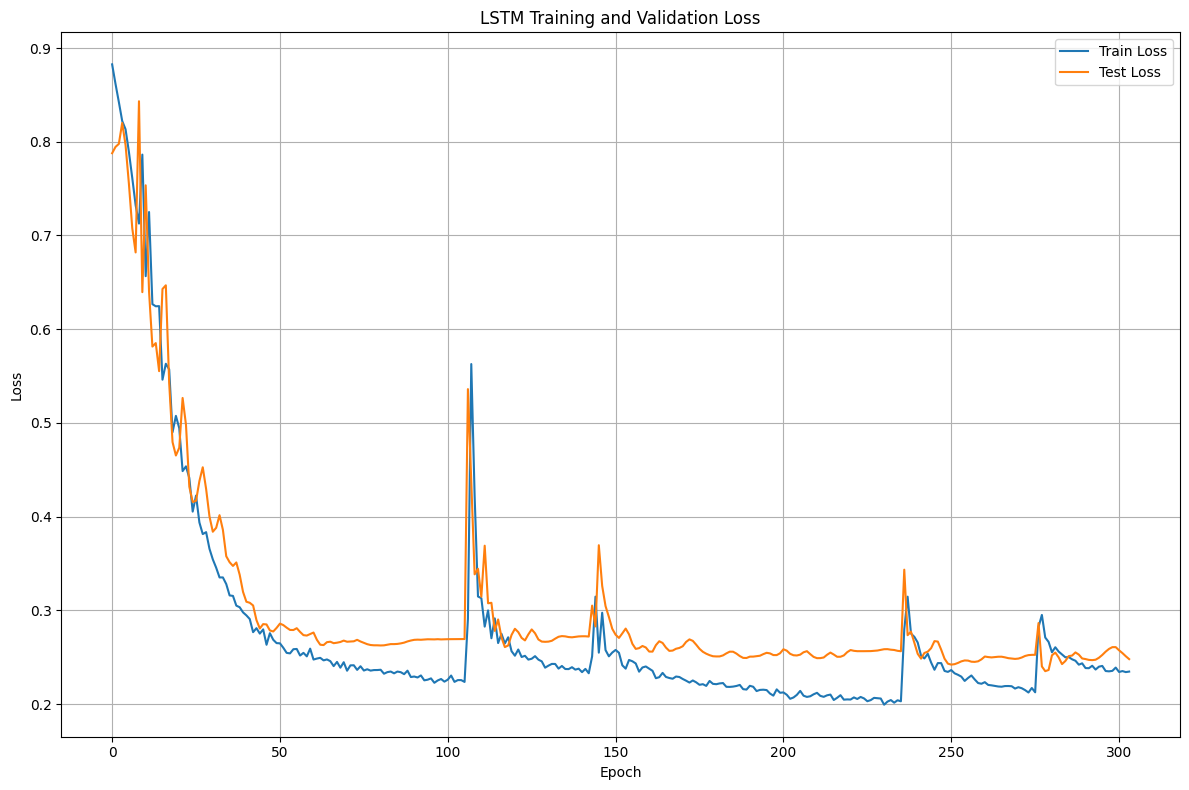

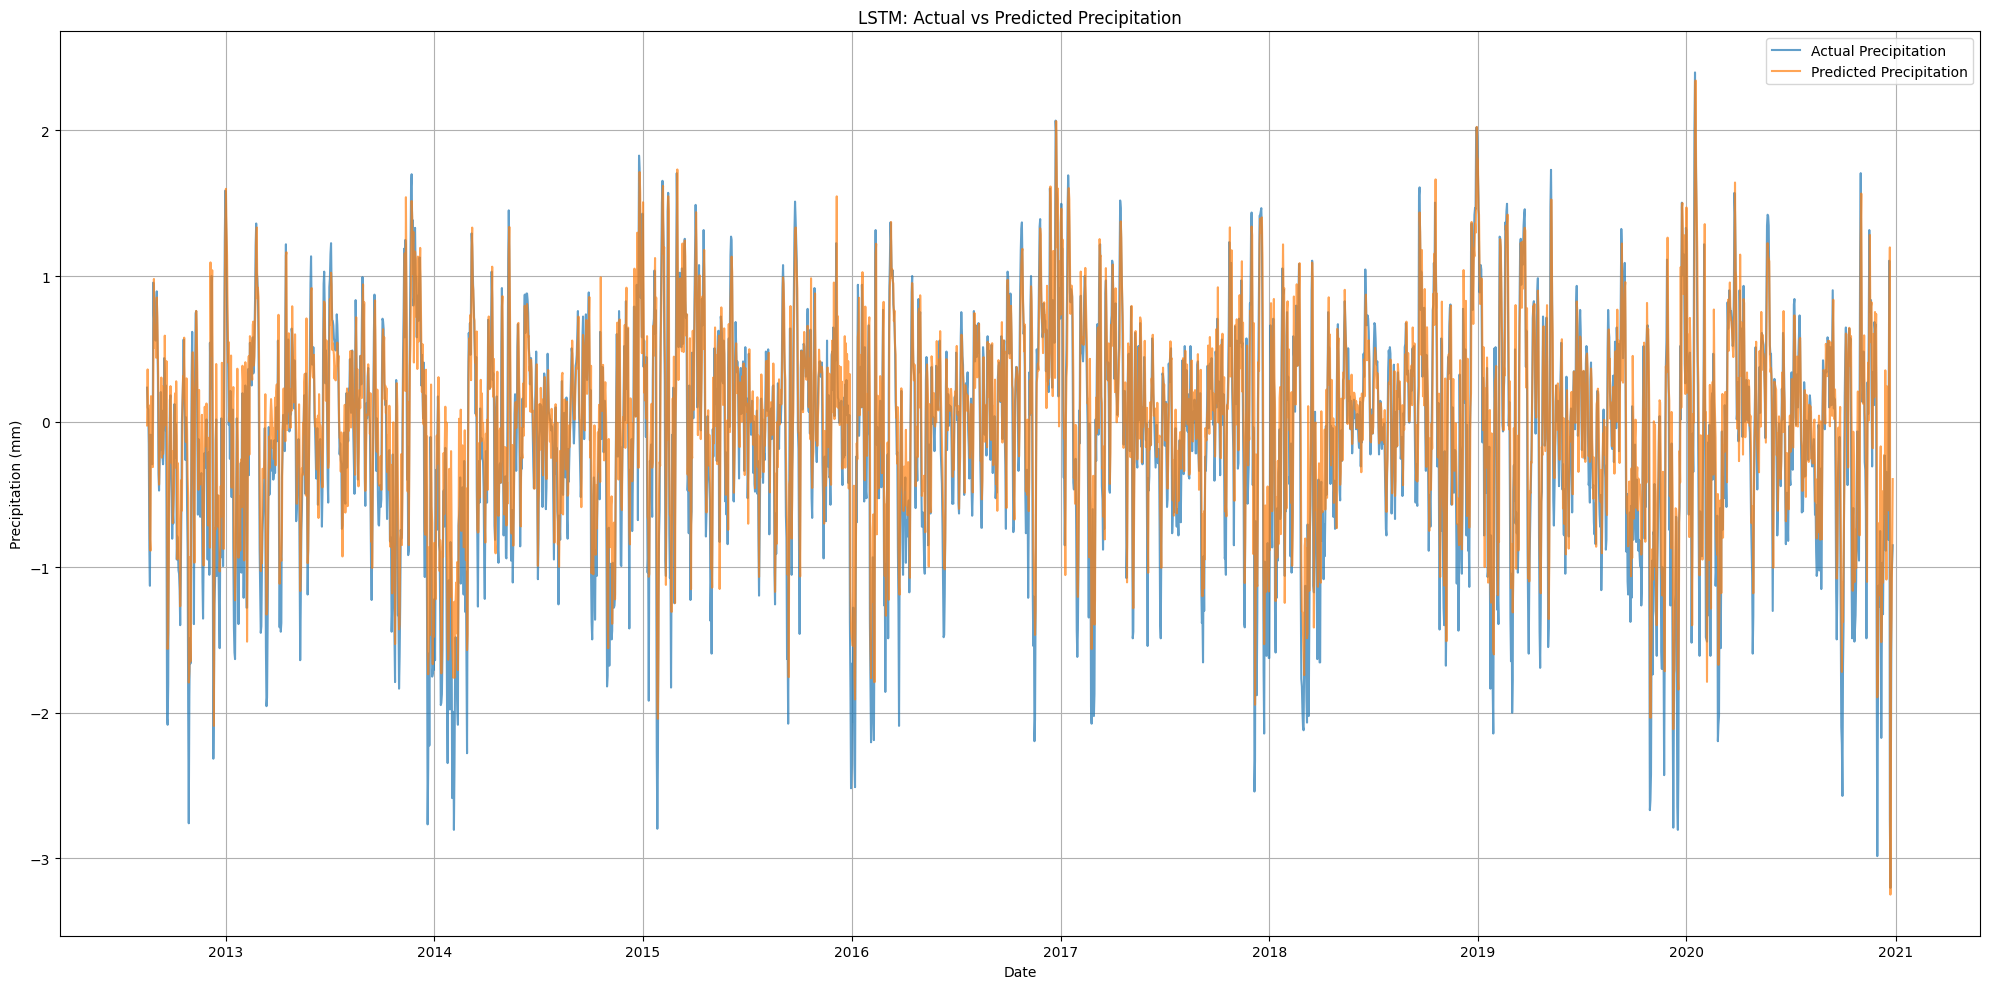

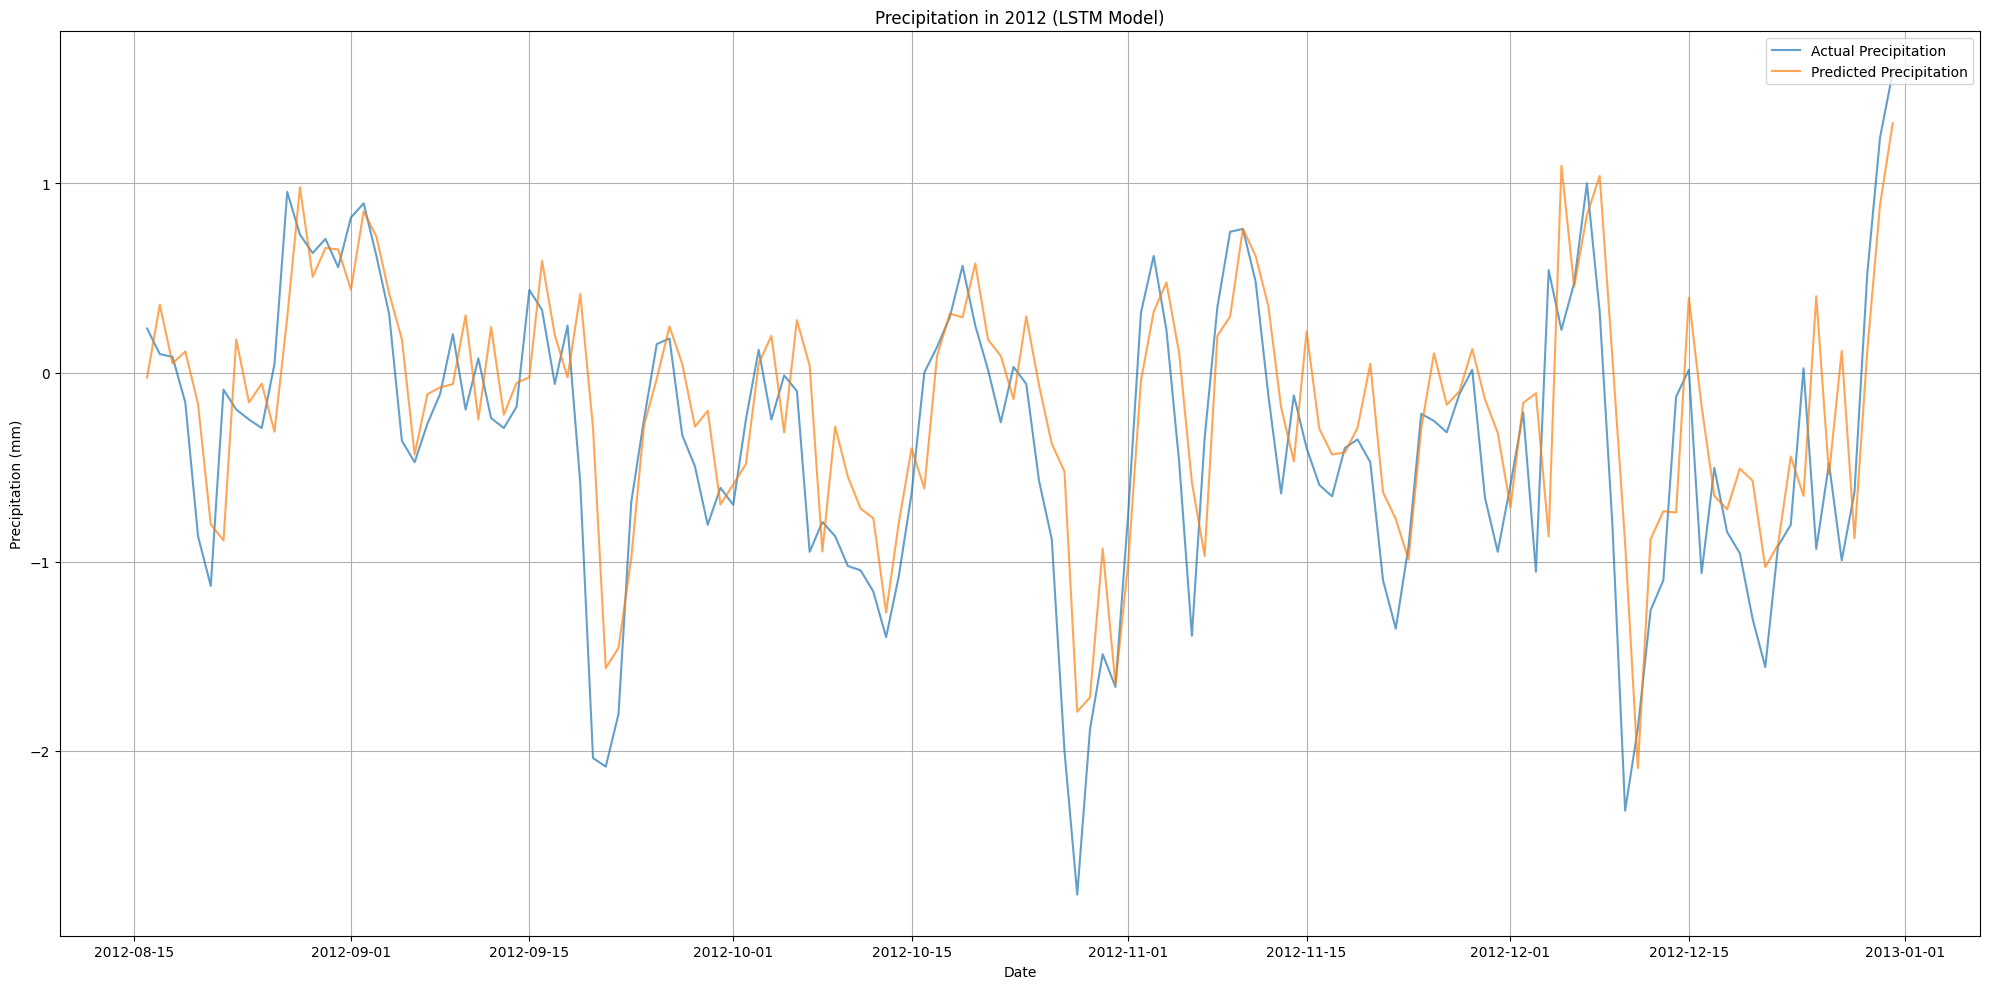

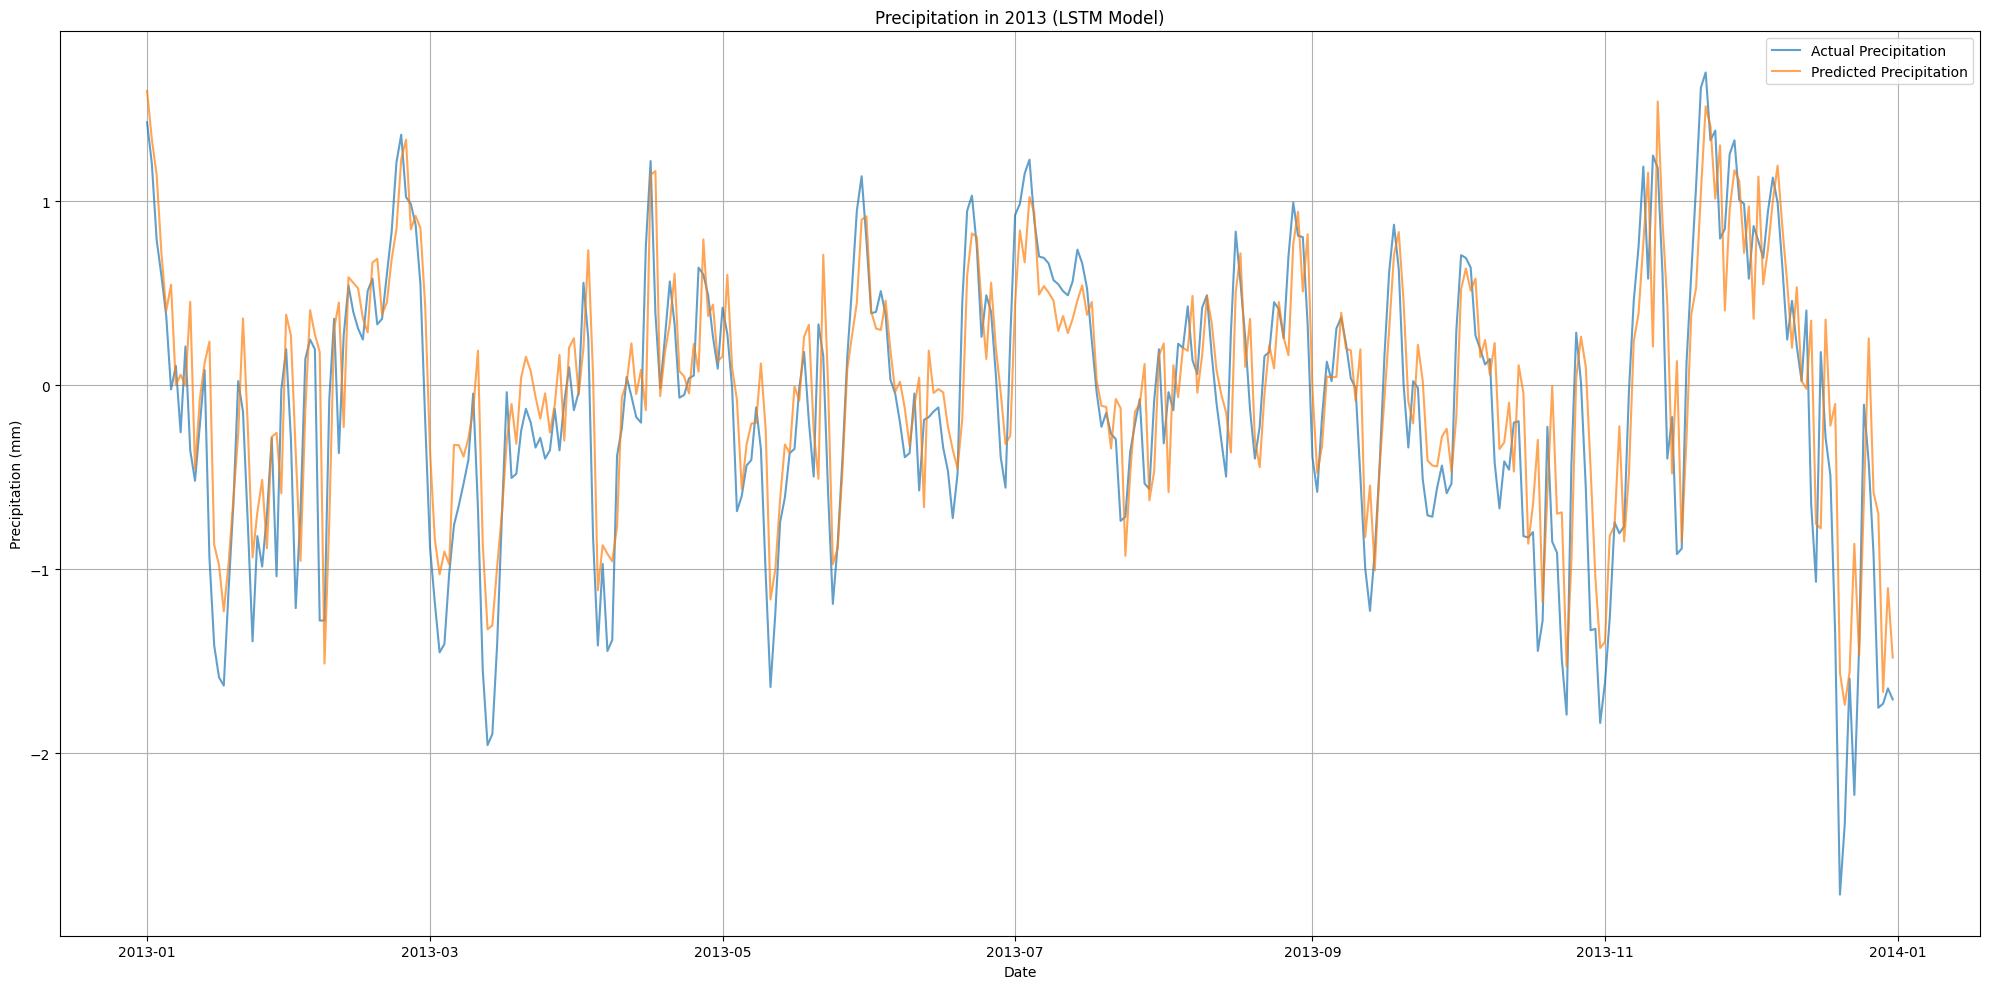

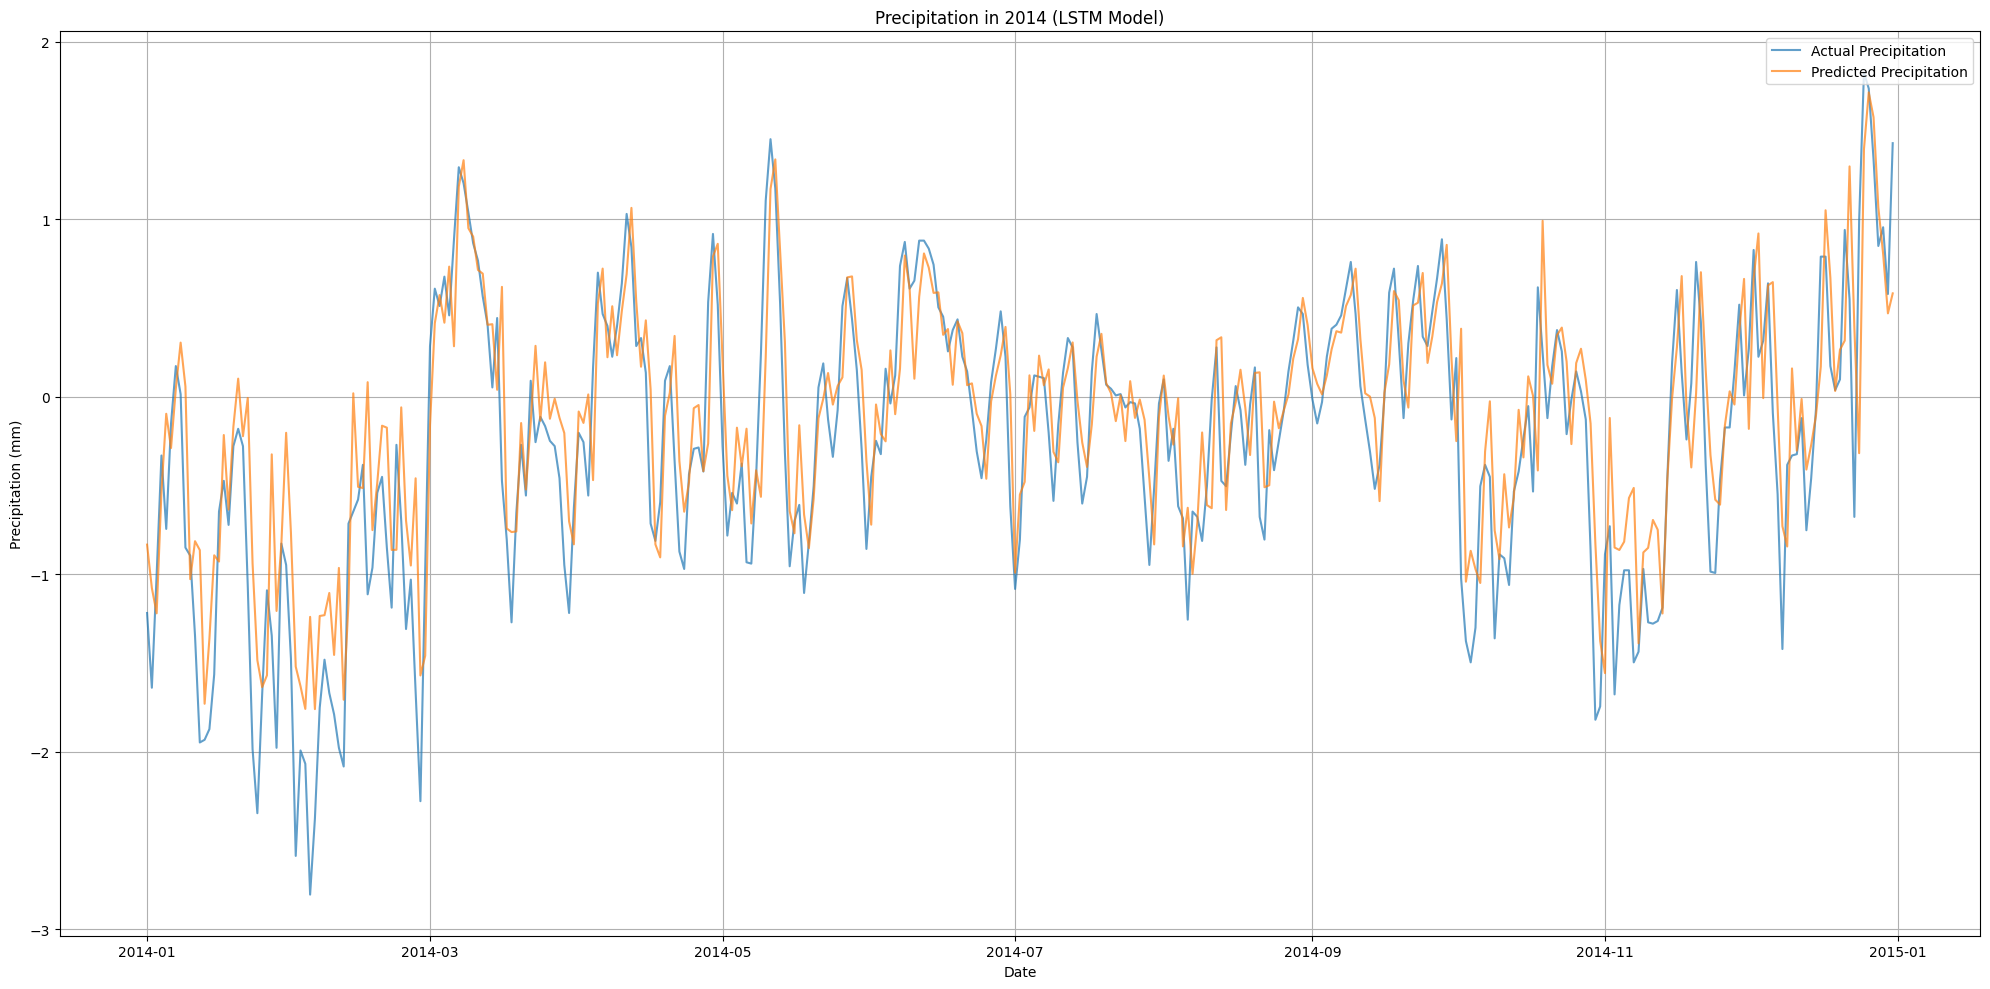

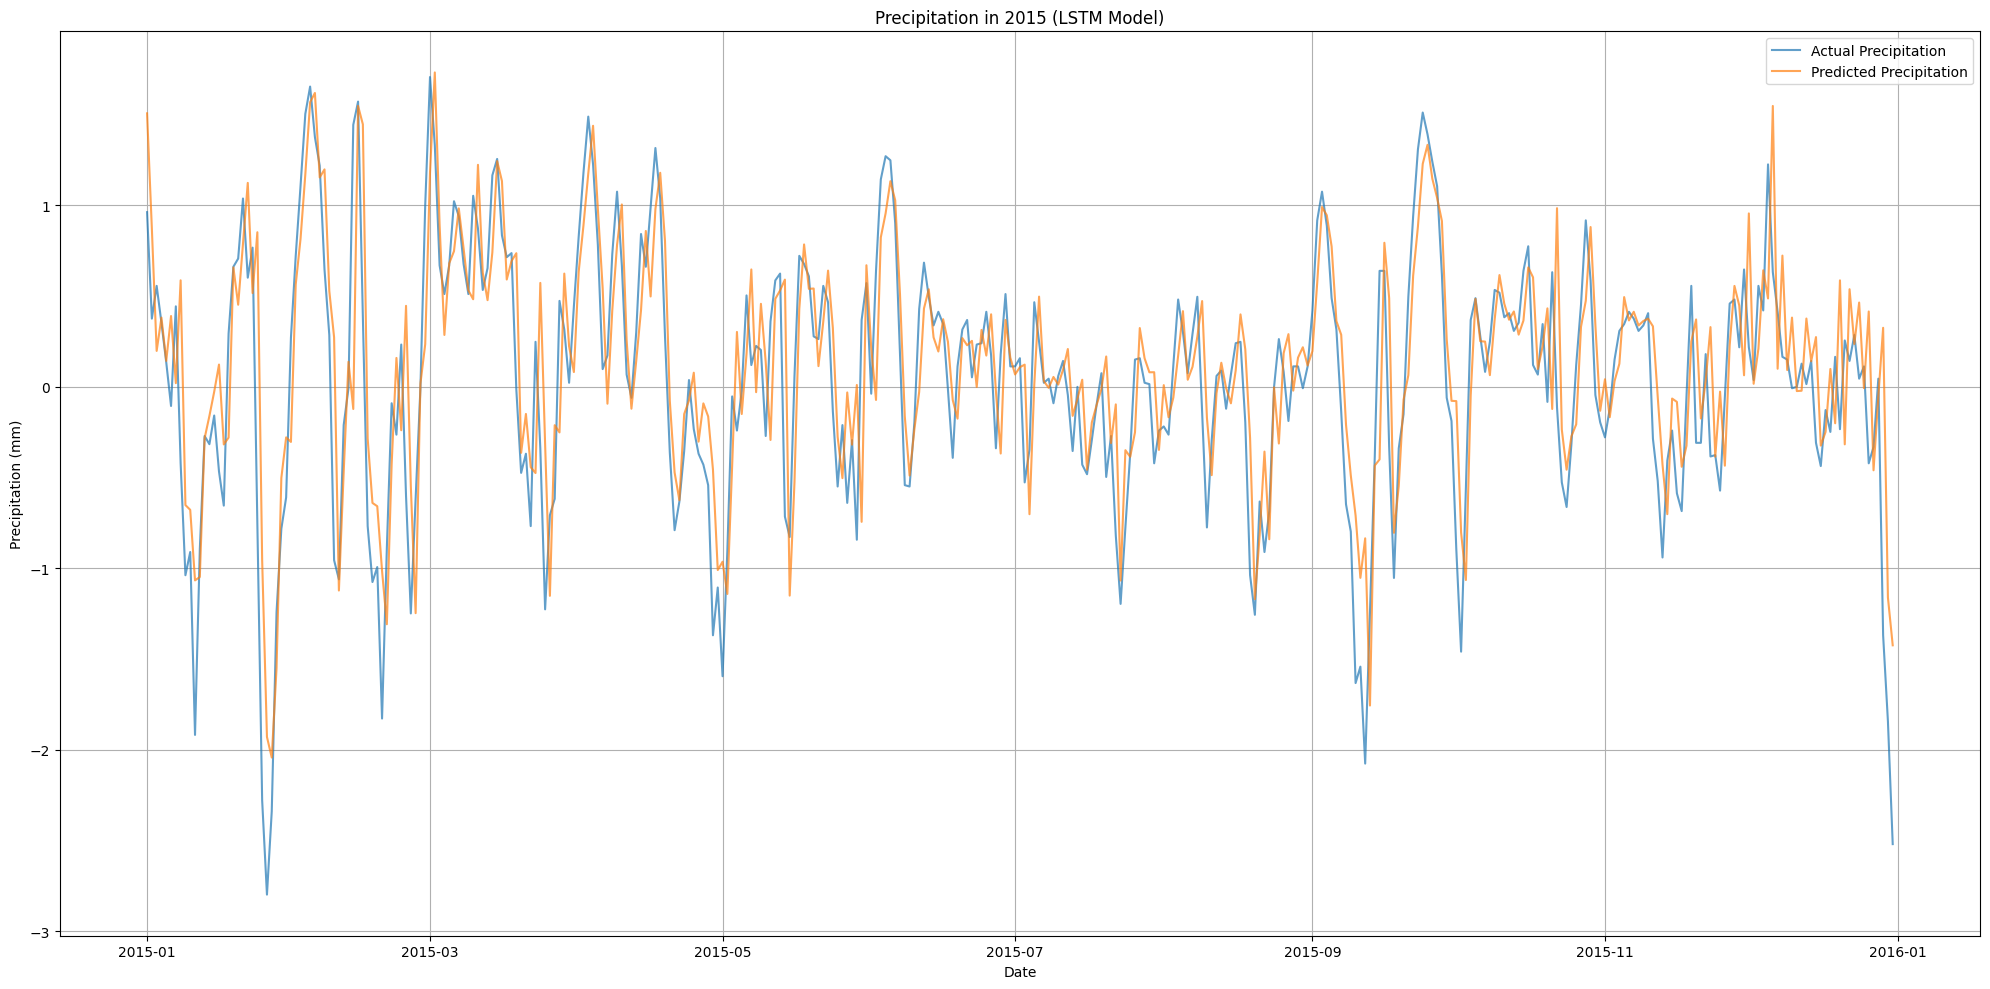

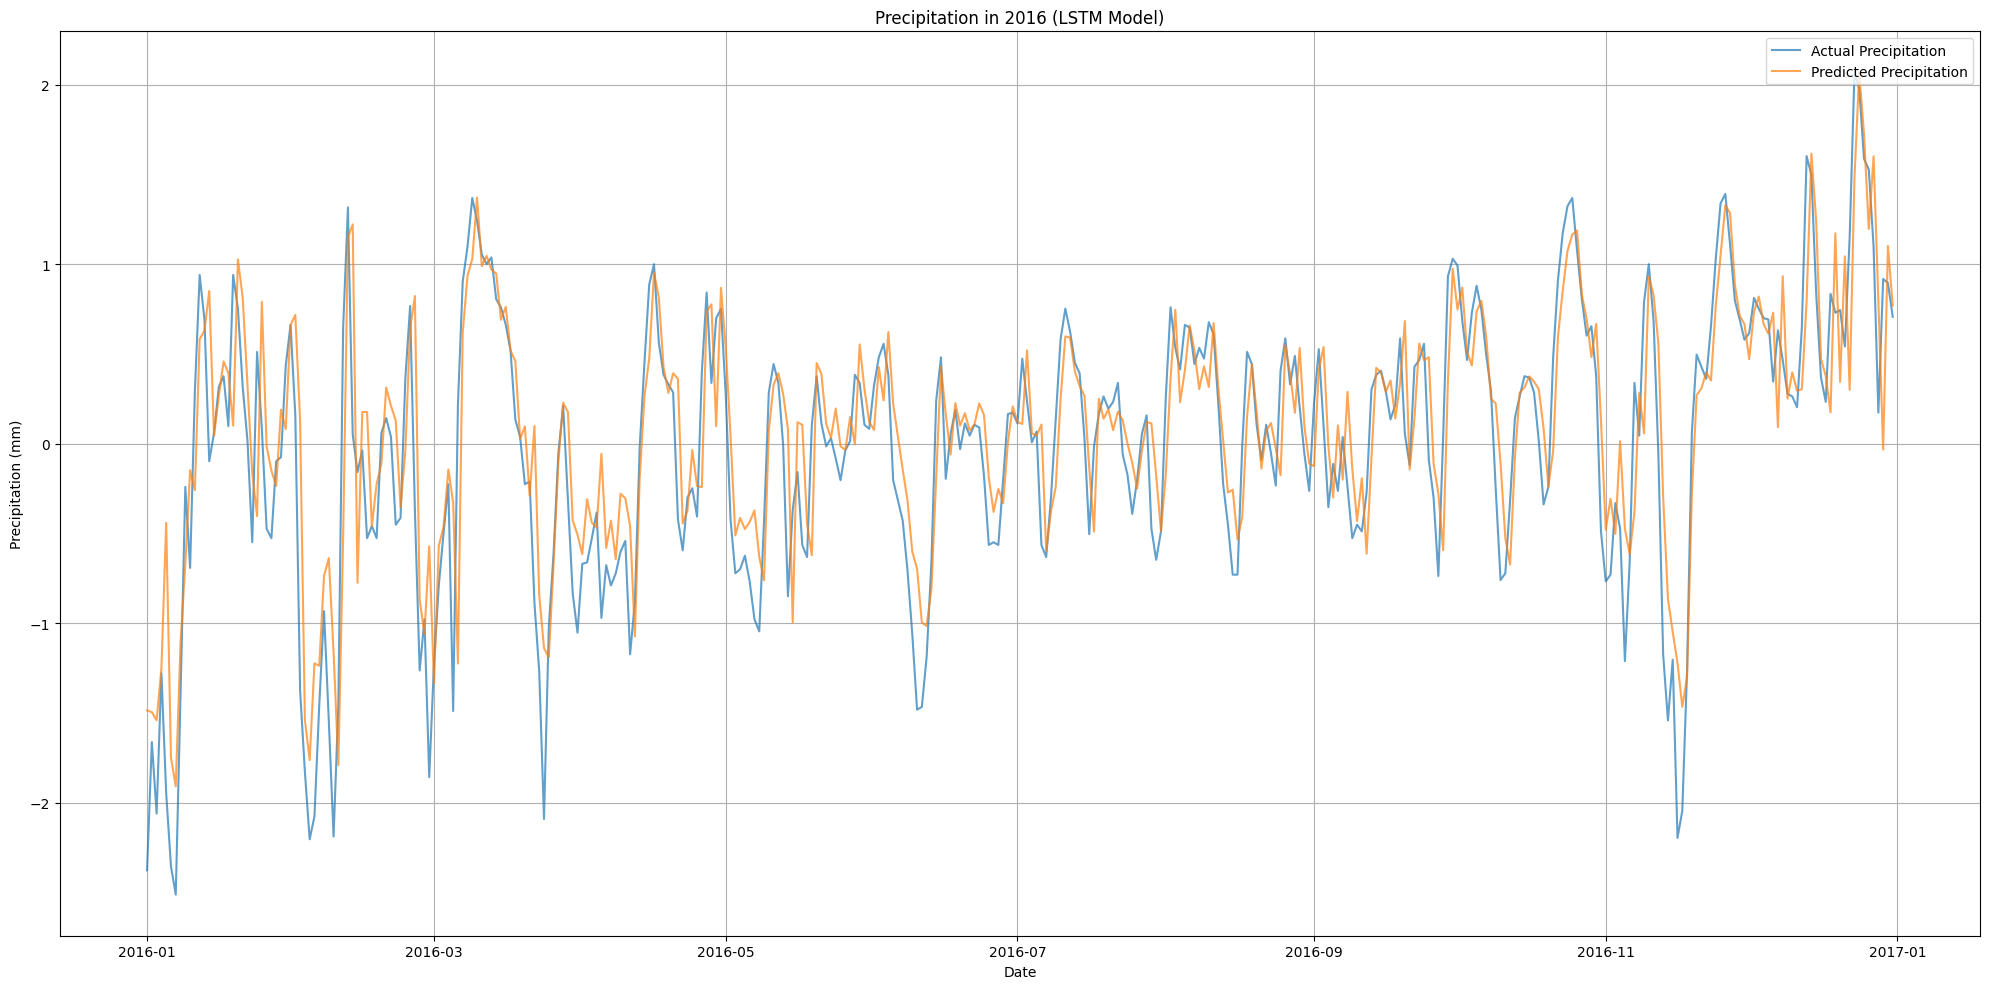

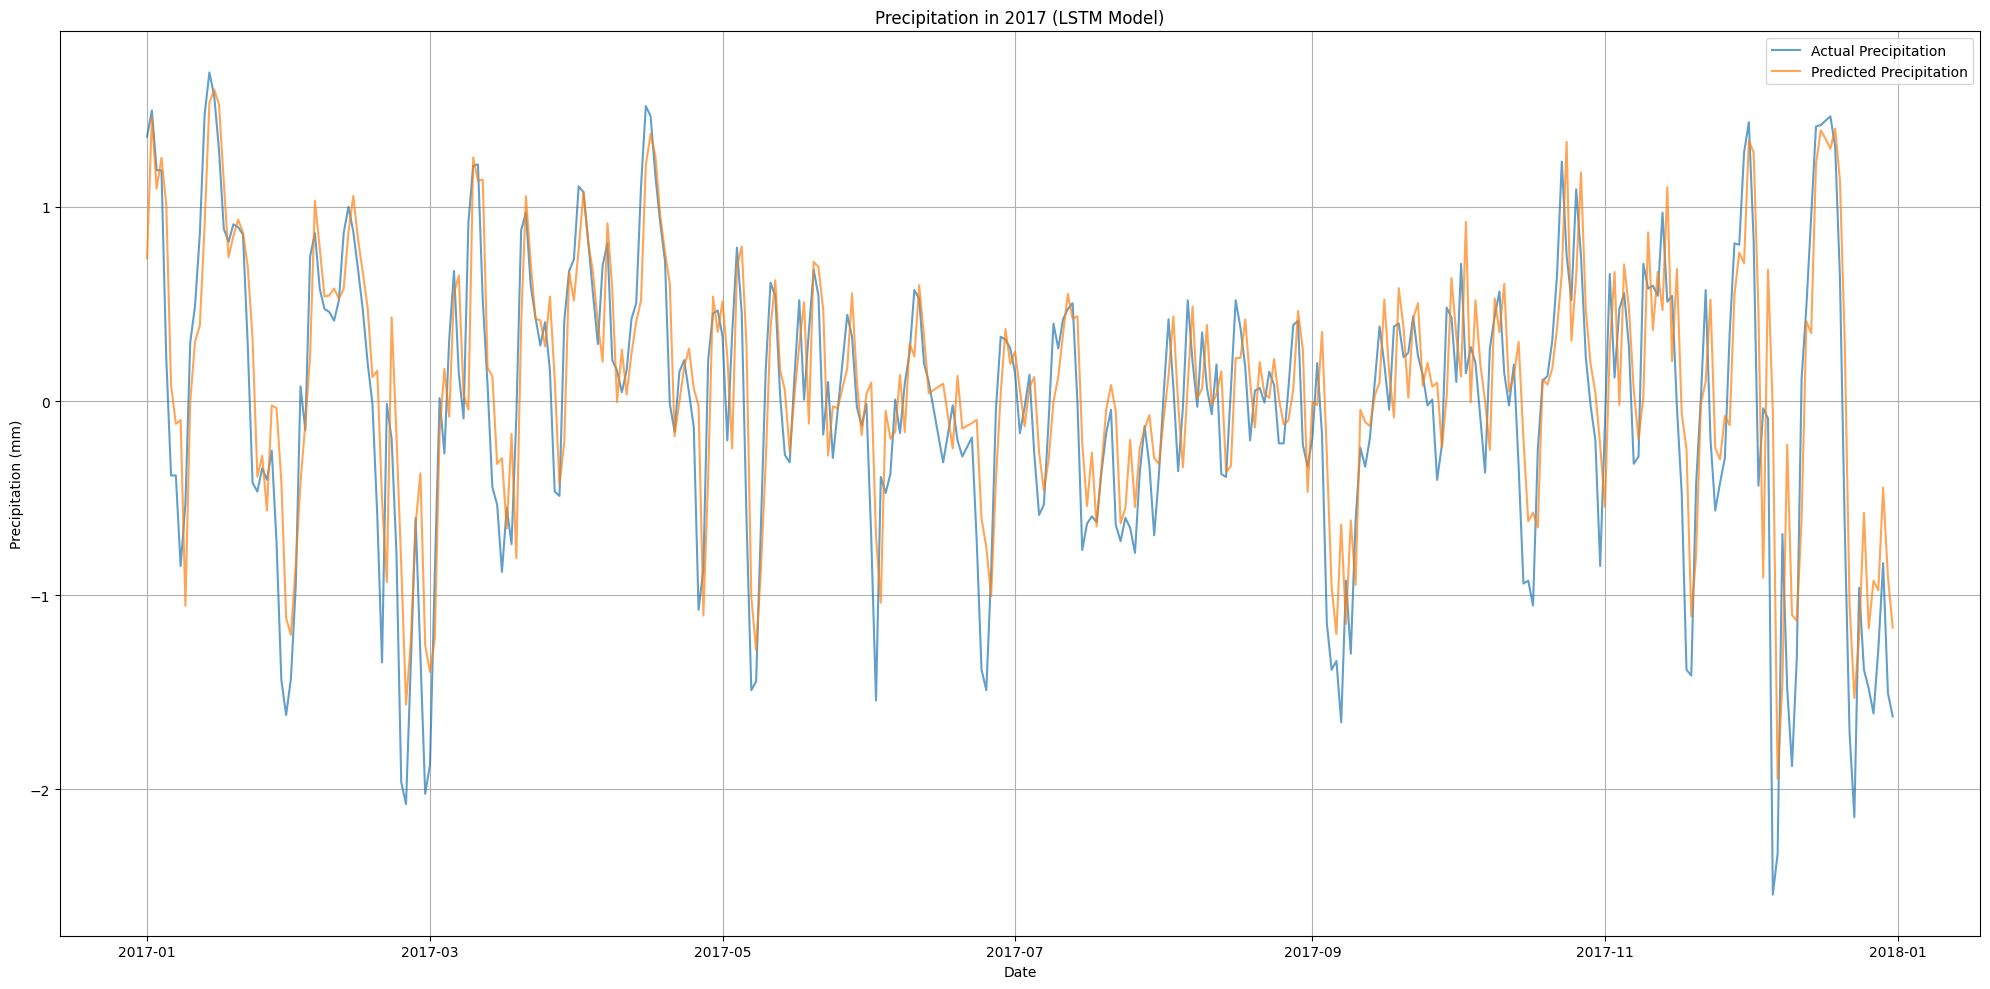

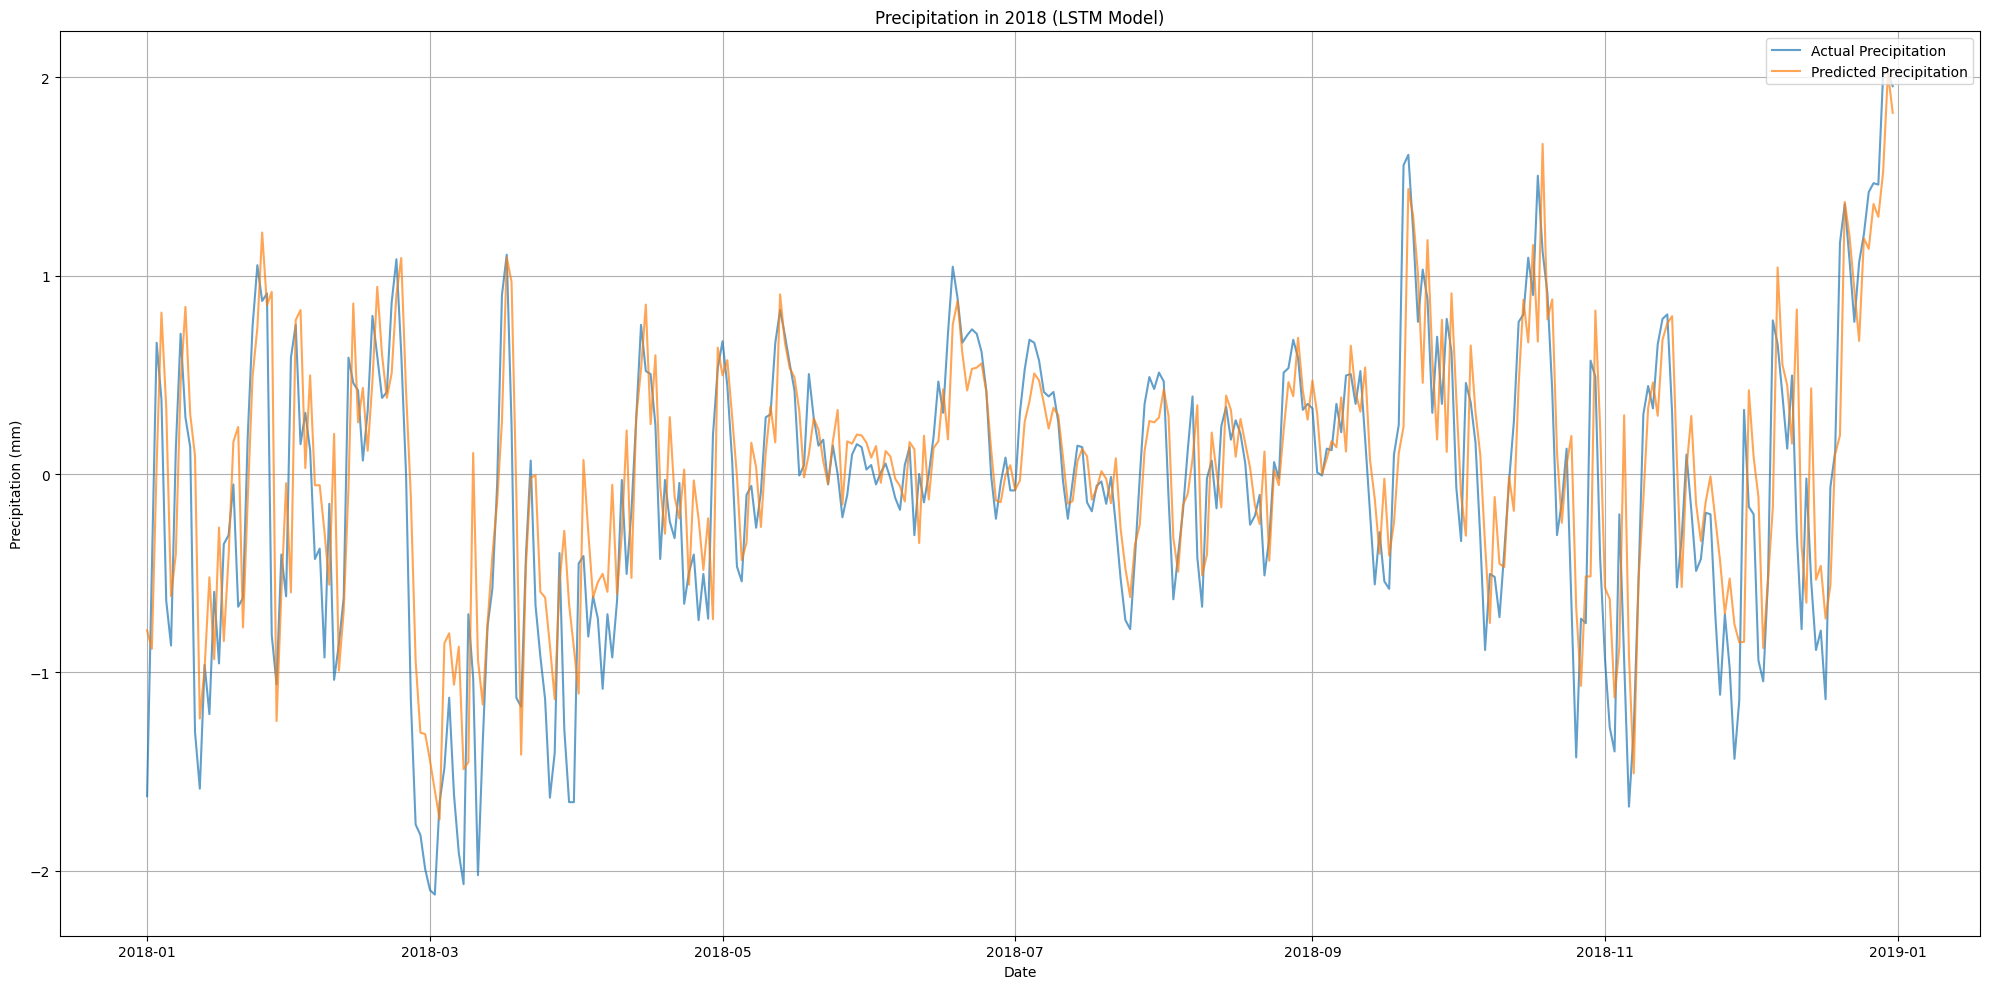

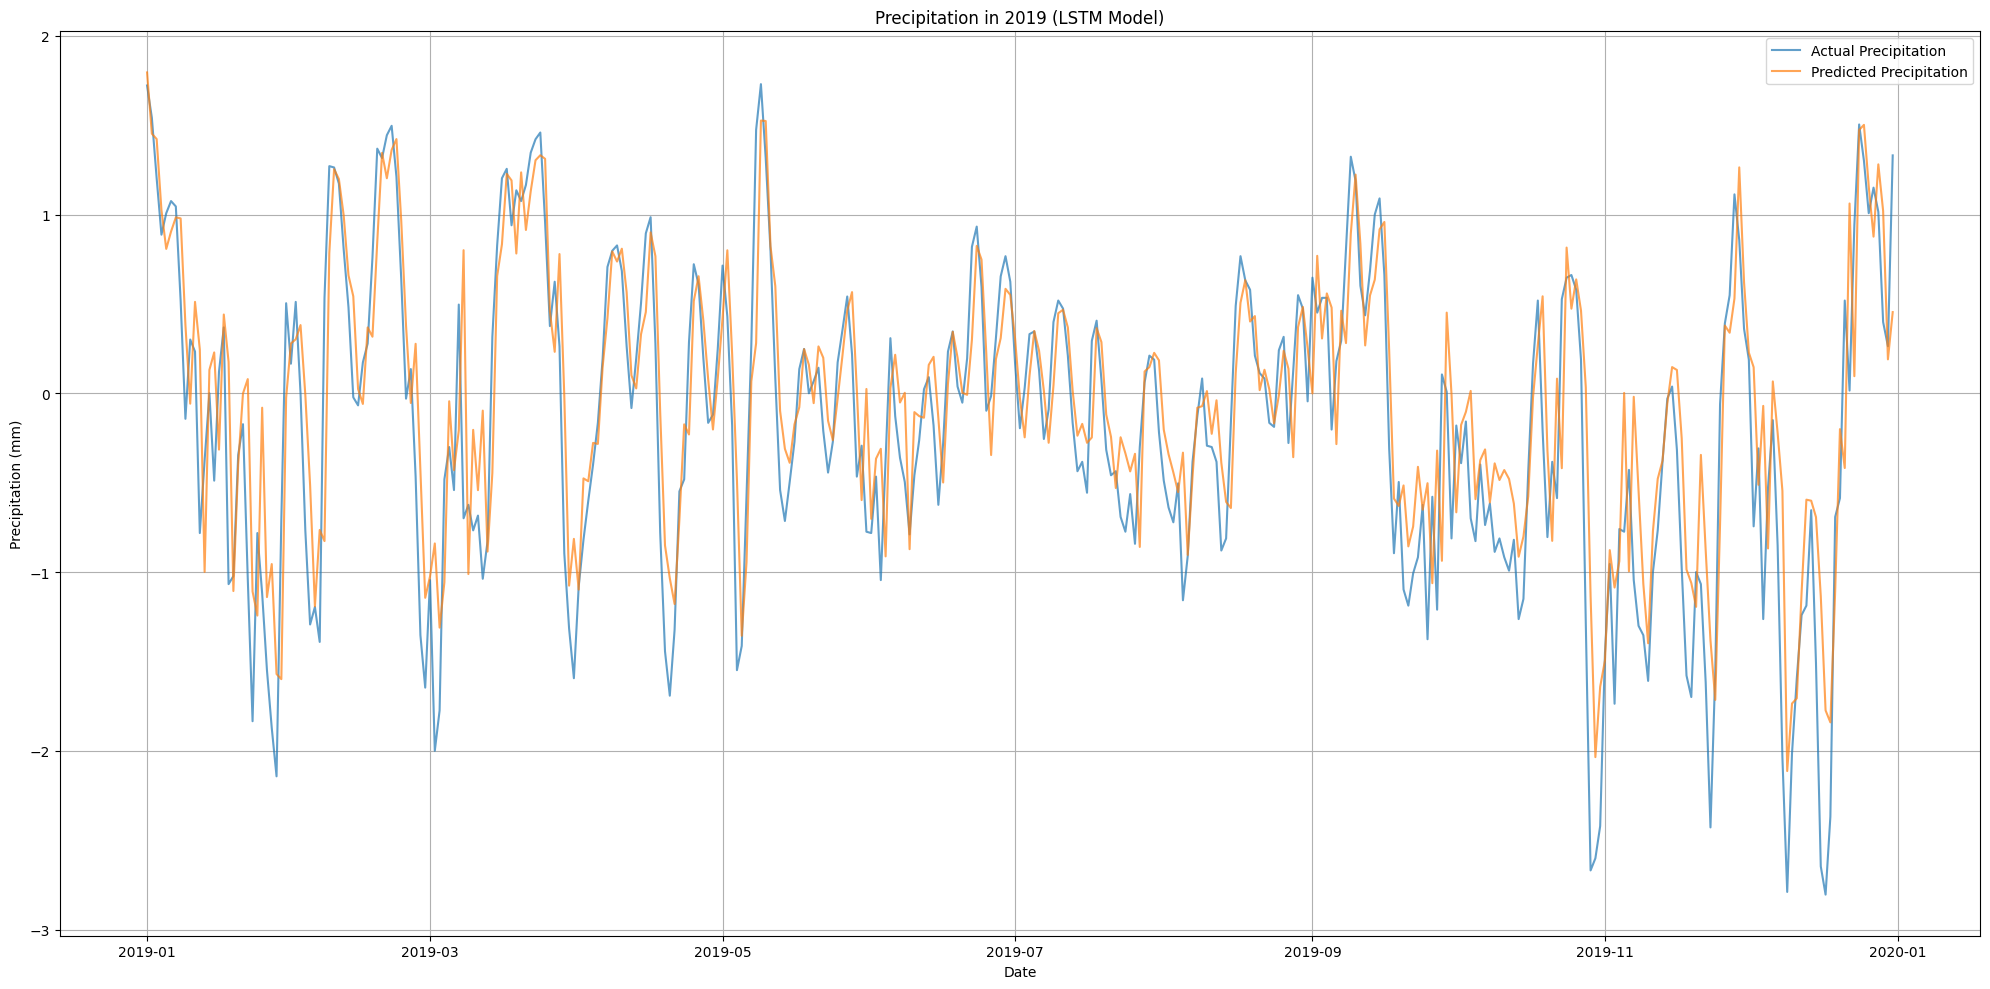

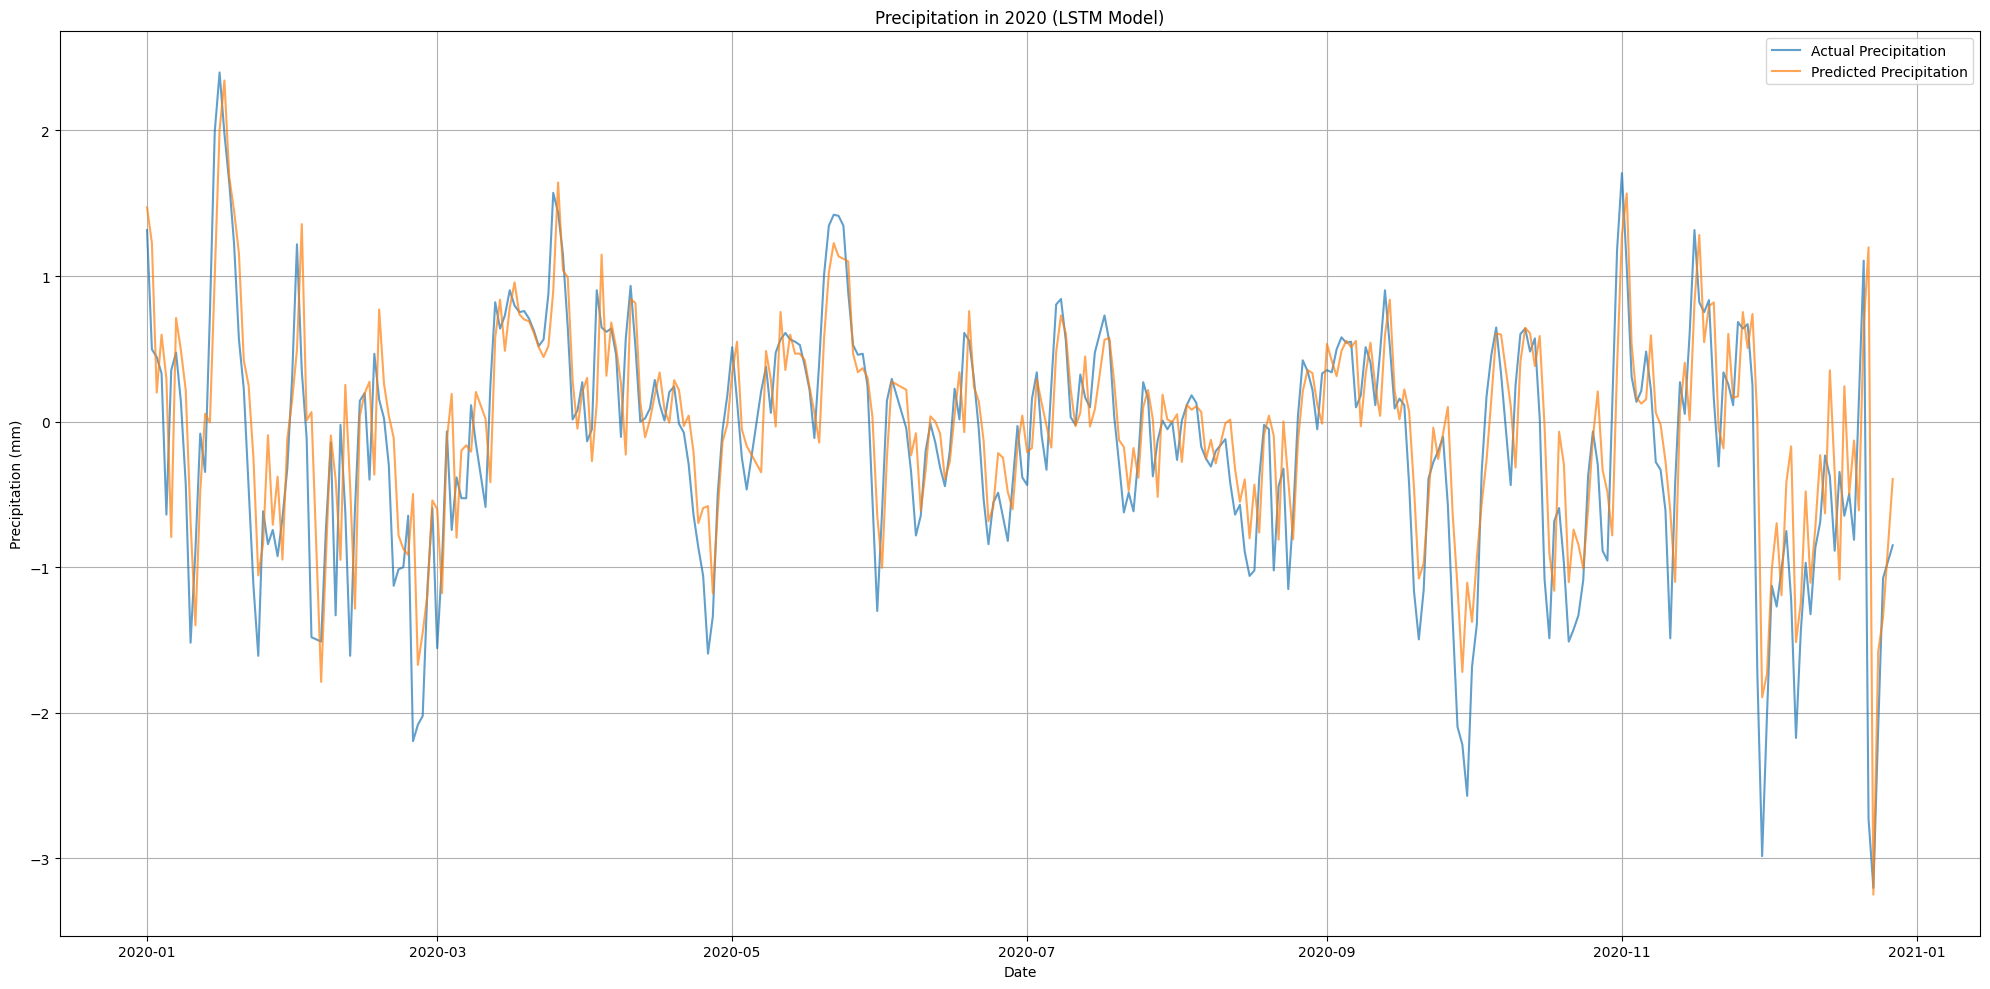

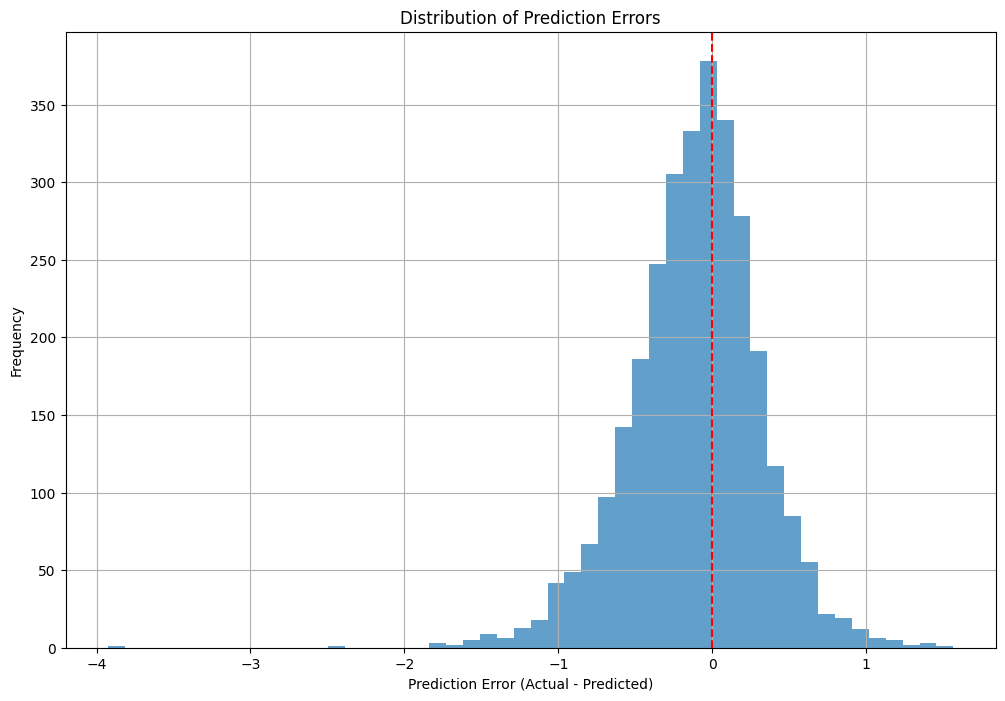

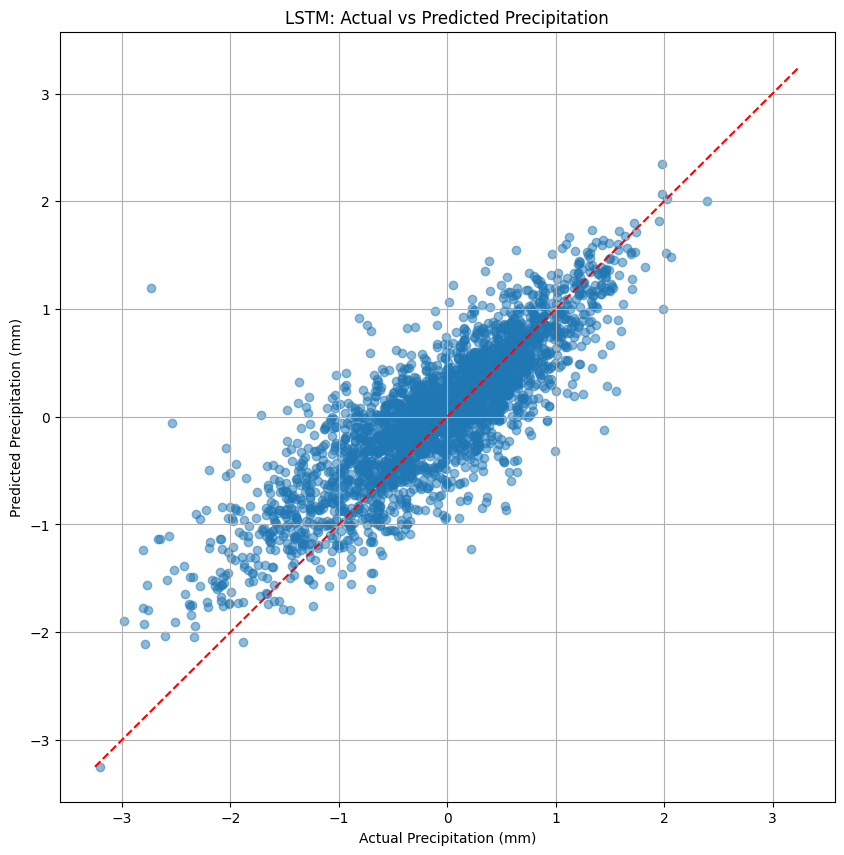


=== LSTM Model Evaluation Metrics ===
MAE: 0.3298
MSE: 0.1951
RMSE: 0.4417
R2: 0.6857

=== Error Statistics ===
mean: -0.11323370784521103
std: 0.4269113540649414
min: -3.926016330718994
max: 1.5654977560043335
median: -0.0841502696275711
zero_precip_mae: 0.2102
non_zero_precip_mae: 0.2549
percent_with_precip: 48.4868
[DISPLAY] Completed in 81.12 seconds
[MAIN] All operations completed
[MAIN] Total execution time: 81.12 seconds

Final LSTM Model Performance Metrics:
MAE: 0.3298
MSE: 0.1951
RMSE: 0.4417
R2: 0.6857


In [11]:
main_start_time = time.time()

# Create thread objects
preprocessor = Preprocessing(FILE_PATH)
trainer = Training(pretrained_model=PRETRAINED_MODEL)
inference = Inference()
analyzer = Analysis()
displayer = Display(
    show_loss_plot=True,
    show_main_plot=True,
    show_yearly_plot=True,
    show_error_hist=True,
    show_scatter_plot=True
)

# Start all threads
preprocessor.start()
trainer.start()
inference.start()
analyzer.start()
displayer.start()

# Wait for all threads to complete
preprocessor.join()
trainer.join()
inference.join()
analyzer.join()
displayer.join()

main_end_time = time.time()
print("[MAIN] All operations completed")
print(f"[MAIN] Total execution time: {main_end_time - main_start_time:.2f} seconds")

# Print final metrics
print("\nFinal LSTM Model Performance Metrics:")
for metric, value in analysis_results['metrics'].items():
    print(f"{metric}: {value:.4f}")